In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import math, os, re, warnings, random
from sklearn.utils import class_weight
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler

Num GPUs Available:  1


In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    
    
seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

In [3]:
strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync 
print('# REPLICAS: {}'.format(REPLICAS))

# REPLICAS: 1


In [4]:
BATCH_SIZE = 32 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 35
HEIGHT = 300
WIDTH = 300
CHANNELS = 3
ES_PATIENCE = 10
AUG_BATCH=BATCH_SIZE
IMAGE_SIZE=[HEIGHT,WIDTH]

In [5]:
GCS_PATH = r'D:/RK/Marwadi University/Sem-8/Project/'

In [6]:
train_dataset_0_all = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

In [7]:
len(train_dataset_0_all)

2397

In [8]:
# Include Validation data as well :-
test_data=pd.read_csv(GCS_PATH + '/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

at = test_data[test_data['labels'] == 1]
ht = test_data[test_data['labels'] == 0]

test_PATH = GCS_PATH + '/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
ATL = [test_PATH +  i for i in list(at.new_names)]
HTL = [test_PATH +  i for i in list(ht.new_names)]

In [9]:
# Merging happens here:-
A=[]
H=[]
A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

print(len(A))
print(len(H))

# Create labels :-
Label_A = [1]*len(A)
Label_H = [0]*len(H)

# Converting to pandas dataframe for easier access:-
A.extend(H)
Label_A.extend(Label_H)
df = pd.DataFrame({'path':A, 'label':Label_A})
df = df.sample(frac=1).reset_index(drop=True)

FILENAMES = df['path']
LABELS = df['label']

print('Final Merged Data:-')
df

7272
3389
Final Merged Data:-


,path,label
0,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,1
1,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,1
2,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,0
3,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,0
4,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,1
...,...,...
10656,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,0
10657,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,1
10658,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,1
10659,D:/RK/Marwadi University/Sem-8/Project/C-NMC_L...,0


In [10]:
cw = class_weight.compute_class_weight('balanced',
                                        np.unique(LABELS),
                                        LABELS)
cw = {0:cw[0], 1:cw[1]}

In [11]:
cw

{0: 1.5728828562997934, 1: 0.7330170517051705}

In [12]:
# Define Augmentation function:-
def data_augment(image, label):
    
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.1)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)
            
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
        
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    
    return image, label

In [13]:
def parse_data(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image)
    image = tf.image.convert_image_dtype(image, tf.float32) /  0.45 
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, tf.one_hot(label,2)

def load_dataset(filenames, labels ,ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_data, num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES,LABELS, ordered=False, repeated=False, augment=False):
    dataset = load_dataset(FILENAMES, LABELS, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [14]:
import math
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    labels = [str(i) for i in  numpy_labels]

    return numpy_images, labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        # image = cv2.imdecode(image,cv2.IMREA)
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    
    
# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

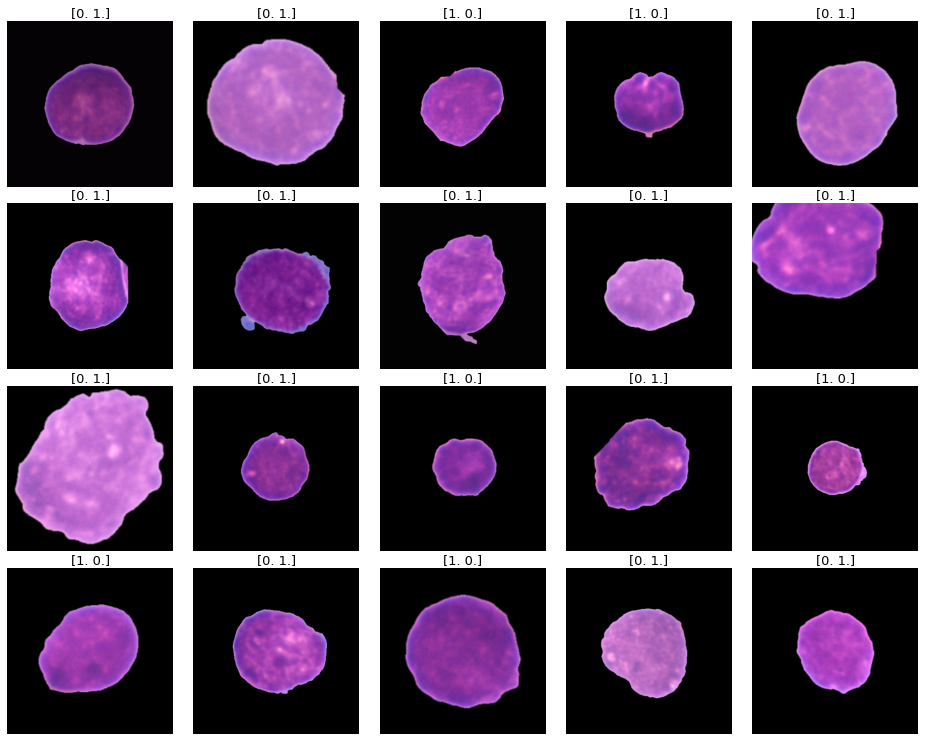

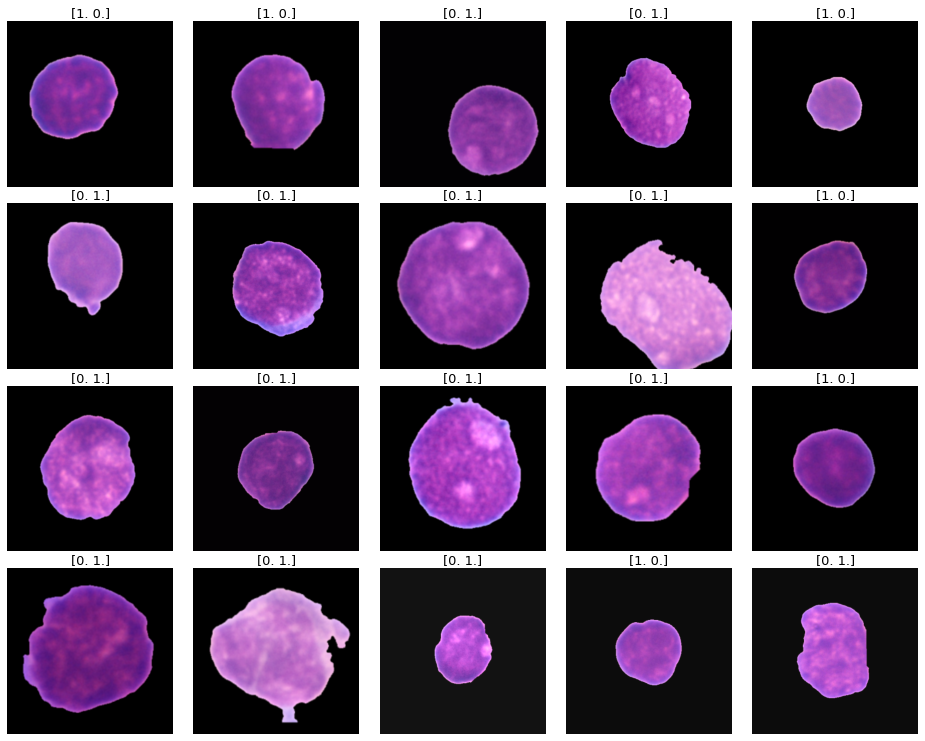

In [15]:
train_dataset = get_dataset(FILENAMES[:60],LABELS[:60], ordered=True,augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Learning rate schedule: 1e-08 to 3e-05 to 7.22e-08


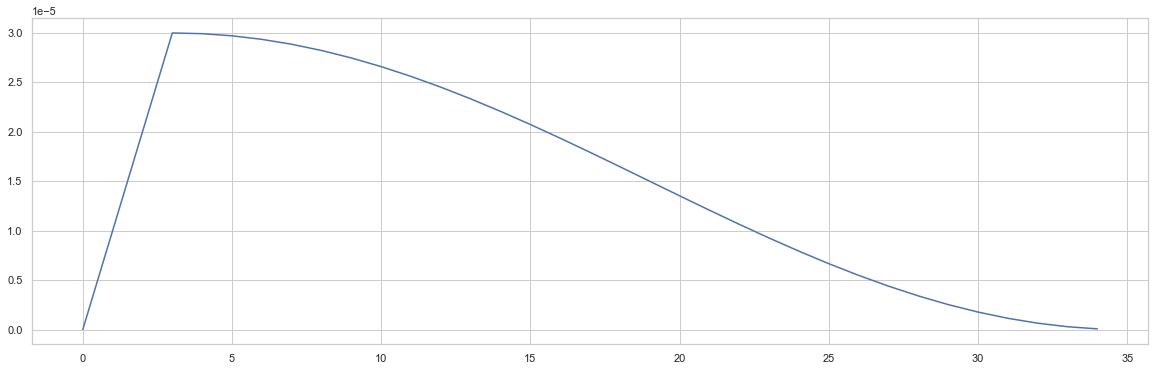

In [21]:
# Cosine Annealing:-
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

# print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [22]:
import tensorflow_addons as tfa

In [23]:
# Model Architecture :-
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = tf.keras.applications.InceptionV3(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')

    for layer in base_model.layers:
        if 'bn' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True
            
    model = tf.keras.Sequential([
        base_model,
        L.Dropout(.25),
        L.Dense(N_CLASSES, activation='sigmoid', name='output')
    ])

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy',tfa.metrics.F1Score(num_classes=2, average='weighted')])
    
    return model

In [24]:
# Cross Validated training loop:-
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []
cv1 = cv2 = 0


for fold,(idxT, idxV) in enumerate(skf.split(FILENAMES,LABELS)):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')
    STEPS_PER_EPOCH = len(idxT) // BATCH_SIZE
    
    
    K.clear_session()
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), 2)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_f1_score', mode='max', 
                    patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(FILENAMES[idxT],LABELS[idxT], ordered=False, repeated=True, augment=True), 
                        validation_data=get_dataset(FILENAMES[idxV],LABELS[idxV] , ordered=True, repeated=False, augment=False), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[es, LearningRateScheduler(lrfn ,verbose=0)], 
                        epochs=EPOCHS,  
                        verbose=1,
                        class_weight = cw).history
      
    model.save_weights(model_path)
    history_list.append(history)
    # Save last model weights

    
    ## RESULTS
    print(f"#### FOLD {fold+1} Accuracy = {np.max(history['accuracy']):.3f}")
    print(f"#### FOLD {fold+1} F1_score = {np.max(history['f1_score']):.3f}")
    cv1 += np.max(history['accuracy'])
    cv2 += np.max(history['f1_score'])
    
    
print(f'### Avg. Accuracy = {cv1/3.0} \n ### Avg. Weighted F1 = {cv2/3.0}')


FOLD: 1
TRAIN: 7107 VALID: 3554
Epoch 1/35
222/222 [==============================] - 84s 278ms/step - loss: 0.7364 - accuracy: 0.4894 - f1_score: 0.5074 - val_loss: 0.7343 - val_accuracy: 0.4927 - val_f1_score: 0.5099 - lr: 1.0000e-08
Epoch 2/35
222/222 [==============================] - 62s 279ms/step - loss: 0.5274 - accuracy: 0.7542 - f1_score: 0.7593 - val_loss: 0.4742 - val_accuracy: 0.7890 - val_f1_score: 0.7950 - lr: 1.0007e-05
Epoch 3/35
222/222 [==============================] - 64s 289ms/step - loss: 0.3639 - accuracy: 0.8557 - f1_score: 0.8570 - val_loss: 0.3309 - val_accuracy: 0.8675 - val_f1_score: 0.8700 - lr: 2.0003e-05
Epoch 4/35
222/222 [==============================] - 66s 296ms/step - loss: 0.3087 - accuracy: 0.8740 - f1_score: 0.8754 - val_loss: 0.2429 - val_accuracy: 0.9060 - val_f1_score: 0.9056 - lr: 3.0000e-05
Epoch 5/35
222/222 [==============================] - 66s 299ms/step - loss: 0.2656 - accuracy: 0.8951 - f1_score: 0.8959 - val_loss: 0.2268 - val_accu

Epoch 10/35
222/222 [==============================] - 69s 312ms/step - loss: 0.1523 - accuracy: 0.9437 - f1_score: 0.9440 - val_loss: 0.1736 - val_accuracy: 0.9381 - val_f1_score: 0.9370 - lr: 2.7472e-05
Epoch 11/35
222/222 [==============================] - 68s 307ms/step - loss: 0.1439 - accuracy: 0.9466 - f1_score: 0.9469 - val_loss: 0.2149 - val_accuracy: 0.9192 - val_f1_score: 0.9204 - lr: 2.6595e-05
Epoch 12/35
222/222 [==============================] - 68s 308ms/step - loss: 0.1274 - accuracy: 0.9503 - f1_score: 0.9506 - val_loss: 0.1757 - val_accuracy: 0.9355 - val_f1_score: 0.9362 - lr: 2.5607e-05
Epoch 13/35
222/222 [==============================] - 68s 307ms/step - loss: 0.1243 - accuracy: 0.9531 - f1_score: 0.9534 - val_loss: 0.1706 - val_accuracy: 0.9386 - val_f1_score: 0.9376 - lr: 2.4516e-05
Epoch 14/35
222/222 [==============================] - 68s 308ms/step - loss: 0.1083 - accuracy: 0.9568 - f1_score: 0.9570 - val_loss: 0.1891 - val_accuracy: 0.9389 - val_f1_score:


FOLD: 1


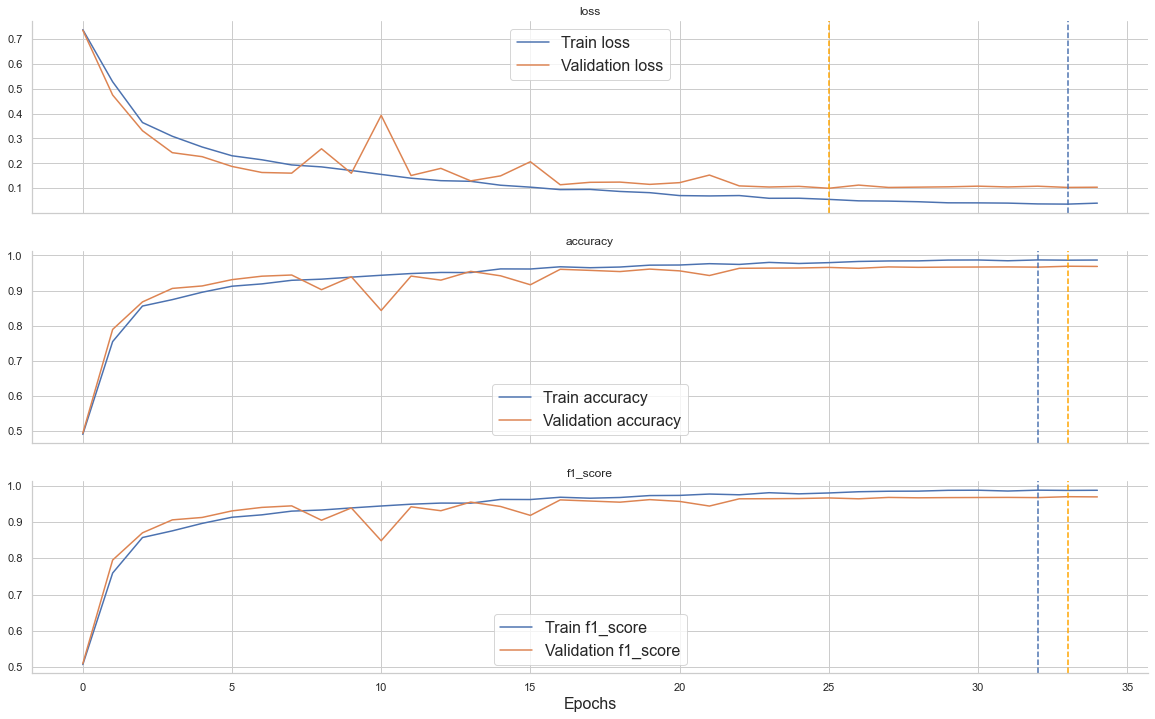


FOLD: 2


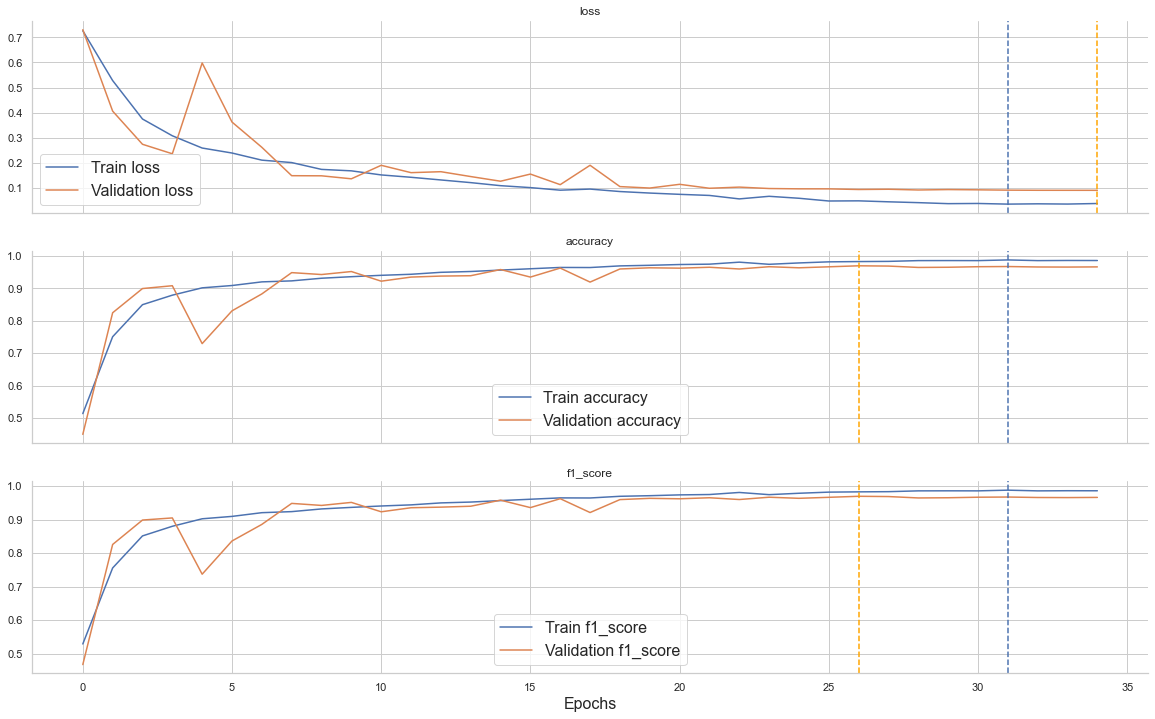


FOLD: 3


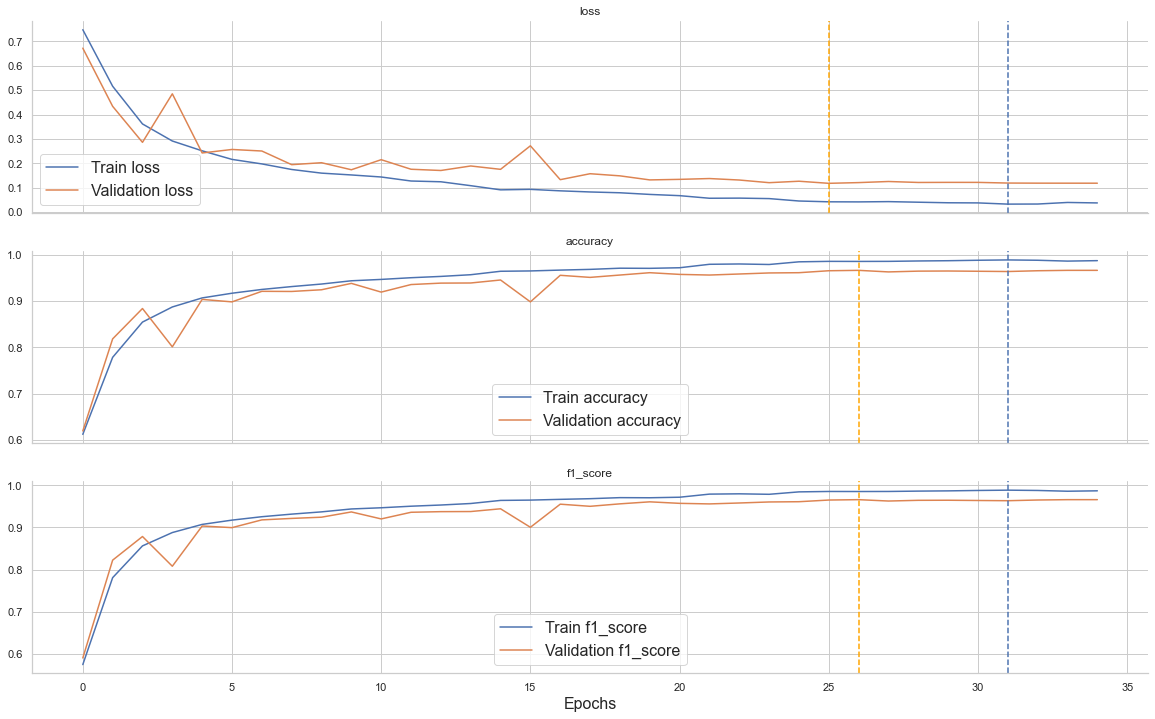

In [25]:
# Plot metrics:-
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

In [26]:
TA=[]
TH=[]

TA.extend(ATL)
TH.extend(HTL)

print(len(TA))
print(len(TH))

# Create labels :-
Label_TA = [1]*len(TA)
Label_TH = [0]*len(TH)

# Converting to pandas dataframe for easier access:-
TA.extend(TH)
Label_TA.extend(Label_TH)
tdf = pd.DataFrame({'path':TA, 'label':Label_TA})
tdf = tdf.sample(frac=1).reset_index(drop=True)
TFILENAMES = tdf['path']
TLABELS = tdf['label']


print('Test Merged Data:-')
tdf

1219
648
Test Merged Data:-


,path,label
0,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,1
1,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,0
2,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,1
3,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,0
4,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,0
...,...,...
1862,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,1
1863,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,1
1864,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,1
1865,D:/RK/Marwadi University/Sem-8/Project//C-NMC_...,1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

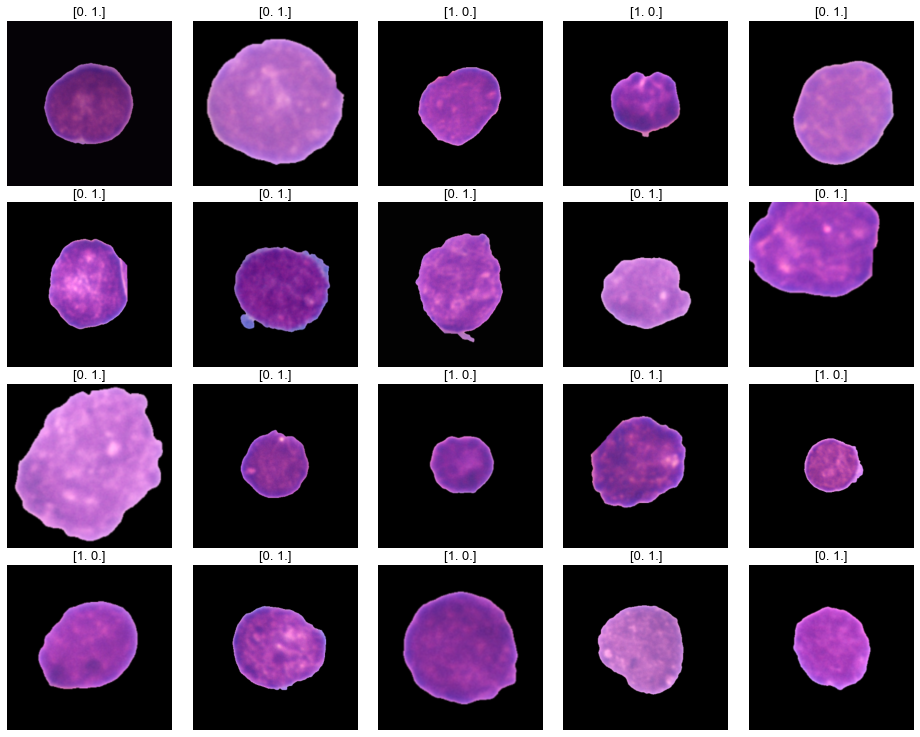

In [27]:
test_dataset = get_dataset(TFILENAMES[:1867],TLABELS[:1867], ordered=True,augment=True)
test_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(test_iter))

In [28]:
accu = model.evaluate(test_dataset)

59/59 [==============================] - 7s 100ms/step - loss: 0.6483 - accuracy: 0.8050 - f1_score: 0.8025


(1, 450, 450, 3)

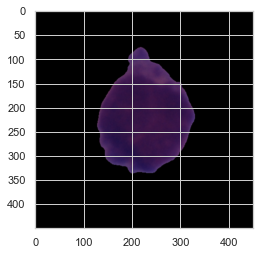

In [29]:
import PIL
from PIL import Image
im1 = Image.open(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_0/all/UID_4_18_1_all.bmp')
p1 = np.array(im1)
plt.imshow(p1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

The Prediction of the sample is: It Is ALL
Prediction Confidence Percentage is:  100.0


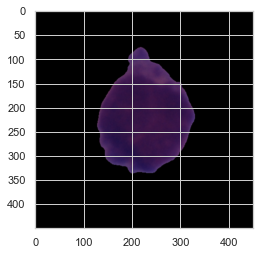

In [30]:
preds = model.predict(p1)
prediction = np.argmax(preds)
pct = np.max(preds)
if prediction == 0:
    print('The Prediction of the sample is: It Is ALL')
else:
    print('Prediction is Hem')
print("Prediction Confidence Percentage is: ", pct*100)
plt.imshow(im1);

94


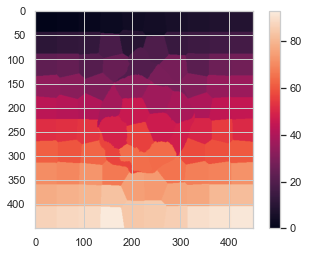

In [31]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
 
segmentation_fn = SegmentationAlgorithm(
    'slic',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=42
)

segments = segmentation_fn(im1)

print(len(np.unique(segments)))

plt.imshow(segments)
plt.colorbar();

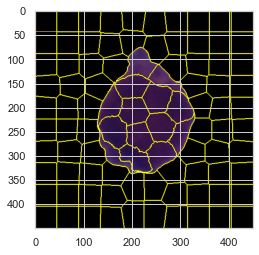

In [32]:
plt.imshow(mark_boundaries(np.array(im1), segments));

In [33]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(im1), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


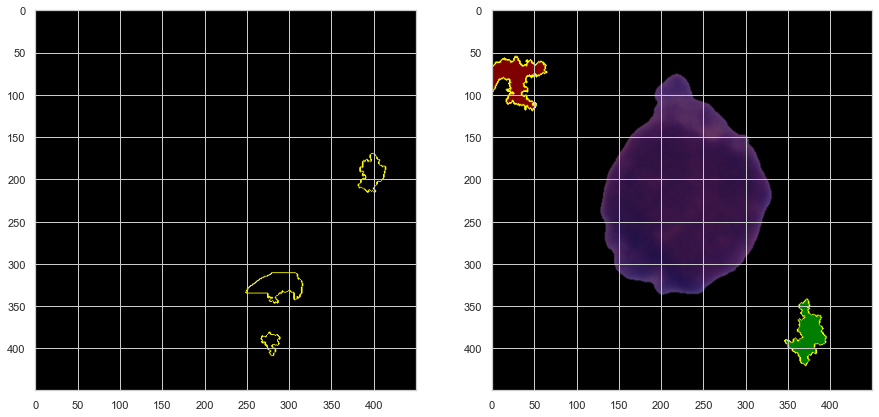

In [34]:
from skimage.segmentation import mark_boundaries


temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2));

In [35]:
from keras.models import model_from_json

In [38]:
path = "D:/RK/Marwadi University/Sem-8/Project/C-NMC_Leukemia/"

In [39]:
model_json = model.to_json()
with open(path+"model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(path+"model.h5")
print("Saved model to disk")

Saved model to disk
